**Mounting Google Drive**
This cell correctly mounts Google Drive to access datasets stored in Google Colab. Simple and essential step for data loading.

In [ ]:
from google.colab import drive
drive. mount('/content/drive')

Mounted at /content/drive


**Extracting Dataset from ZIP**
Efficiently extracts the dataset from a ZIP file into the local directory — a common practice for managing large datasets in Colab.

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/cats_vs_dogs_small.zip","r") as zip_ref:
    zip_ref.extractall("/content")

**Verifying Dataset Structure**
Lists the contents of the base directory to confirm the dataset has been extracted correctly and is organized into train, validation, and test folders.

In [ ]:
import os
base_dir = "/content/cats_vs_dogs_small"
print( "Contents of the base directory:", os.listdir(base_dir))

Contents of the base directory: ['test', 'validation', 'train']


**Installing TensorFlow**
Installs TensorFlow, which is essential for building and training deep learning models. This is necessary if it’s not pre-installed.

In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 1.3 MB/s eta 0:00:00


**Importing Libraries and Setting Paths**
Well-organized import block and dataset paths setup; this prepares the environment for model development and data loading.

In [ ]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications

# Set the correct path to your dataset
training_path = '/content/cats_vs_dogs_small/train'
validation_path = '/content/cats_vs_dogs_small/validation'
testing_path = '/content/cats_vs_dogs_small/test'

**Loading the Datasets**
This block uses TensorFlow's image_dataset_from_directory to load and preprocess the train, validation, and test datasets efficiently. Specifying image size and batch size ensures consistent input shape and manageable computation during training.

In [ ]:
# Load datasets
ds_train = keras.preprocessing.image_dataset_from_directory(
    training_path,
    image_size=(180, 180),
    batch_size=32)

ds_val = keras.preprocessing.image_dataset_from_directory(
    validation_path,
    image_size=(180, 180),
    batch_size=32)

ds_test = keras.preprocessing.image_dataset_from_directory(
    testing_path,
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Displaying Sample Images**
This function is a great way to visually inspect a batch of training images and verify that labels are correctly assigned. The use of plt.subplot provides a clean 3x3 grid layout, which helps in getting a quick feel for the dataset.

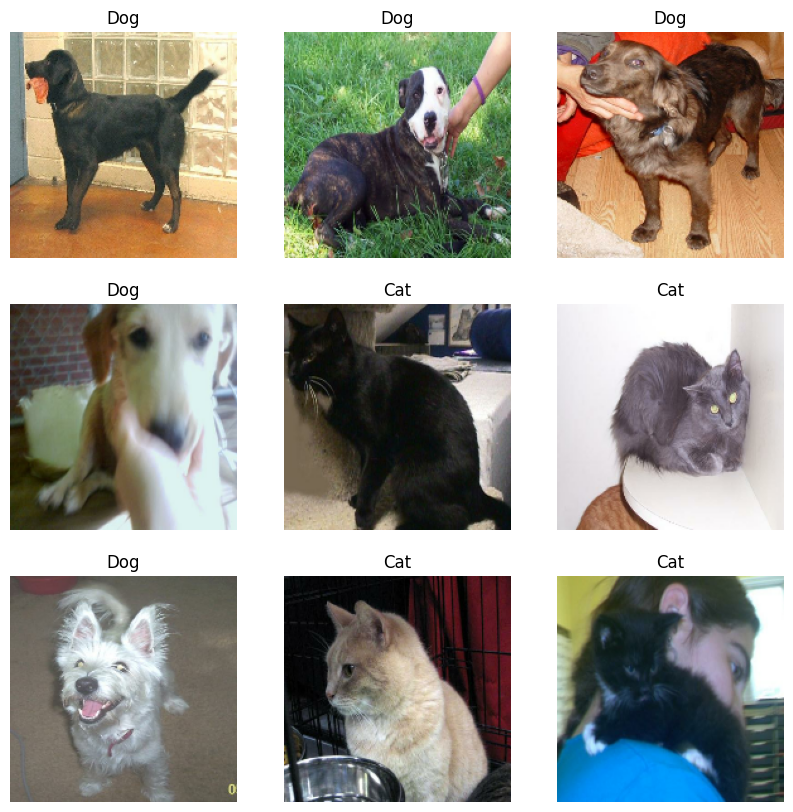

In [ ]:
# Display sample images
def show_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, model_labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Cat" if model_labels[i] == 0 else "Dog")
            plt.axis("off")
    plt.show()

# Call the function to display images
show_images(ds_train)

**Custom CNN Model Definition**
This function builds a straightforward but effective CNN architecture for binary classification. The increasing number of filters and use of max pooling layers help extract spatial features, while the final dense layers classify the images. Using sigmoid activation and binary_crossentropy is appropriate for the two-class (cat vs. dog) problem.

In [ ]:
# Function to create a CNN model from scratch
def build_custom_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


**Data Augmentation and Generator Setup**
This function enhances the training dataset using real-time data augmentation, which helps improve model generalization. It uses ImageDataGenerator to apply transformations like rotation, zoom, and flipping, which are especially useful for image classification tasks. The validation generator is appropriately left unaugmented to ensure consistent evaluation.

In [ ]:
# Data augmentation and preprocessing with sample size parameter
def prepare_data_flows(training_path, validation_path, batch_size, num_samples=None):
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    gen_train = train_datagen.flow_from_directory(
        training_path,
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='binary'
    )

    val_generator = val_datagen.flow_from_directory(
        validation_path,
        target_size=(180, 180),
        batch_size=batch_size,
        class_mode='binary'
    )

    return gen_train, val_generator


**Model Training Function**
This function handles the training loop using the fit method and tracks performance over epochs. Returning the history object is useful for later analysis or visualization of training and validation metrics.

In [ ]:
# Train the model
def fit_model(model, gen_train, gen_val, epochs=30):
    history = model.fit(gen_train,
                        validation_data=gen_val,
                                epochs=epochs)
    return history



**Training the Baseline Model (Model A)**
This step initiates training of the custom CNN using a smaller subset of 1000 training samples, which is useful for benchmarking and observing the impact of limited data. The modular approach with reusable functions keeps the workflow clean and flexible.

In [ ]:
# Step 1: Train model from scratch with 1000 samples
train_generator_1, validation_generator_1 = prepare_data_flows(training_path, validation_path, batch_size=32, num_samples=1000)

model_A = build_custom_model()

history_A = fit_model(model_A, train_generator_1, validation_generator_1)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 394ms/step - accuracy: 0.5164 - loss: 0.7758 - val_accuracy: 0.5340 - val_loss: 0.6888
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step - accuracy: 0.5536 - loss: 0.6817 - val_accuracy: 0.5500 - val_loss: 0.6879
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step - accuracy: 0.5283 - loss: 0.6808 - val_accuracy: 0.5470 - val_loss: 0.7453
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - accuracy: 0.5976 - loss: 0.6639 - val_accuracy: 0.6200 - val_loss: 0.6279
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 387ms/step - accuracy: 0.6259 - loss: 0.6361 - val_accuracy: 0.6420 - val_loss: 0.6397
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 392ms/step - accuracy: 0.6591 - loss: 0.6311 - val_accuracy: 0.6790 - val_loss: 0.5920
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step - accuracy: 0.6733 - loss: 0.6000 - val_accuracy: 0.6550 - val_loss: 0.6097
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - accuracy: 0.6611 - loss: 0.6142 - val_accu

**Training with More Data (Model B)**
This step increases the sample size to 1500, which allows you to observe how model performance improves with more training data. Keeping the model architecture consistent helps isolate the effect of dataset size.

In [ ]:
# Step 2: Increase training samples to 1500
train_generator_2, validation_generator_2 = prepare_data_flows(training_path, validation_path, batch_size=32, num_samples=1500)
model_B = build_custom_model()
history_B = fit_model(model_B, train_generator_2, validation_generator_2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 383ms/step - accuracy: 0.4924 - loss: 1.1050 - val_accuracy: 0.5000 - val_loss: 0.6911
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.5044 - loss: 0.6931 - val_accuracy: 0.5320 - val_loss: 0.6919
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.5144 - loss: 0.6913 - val_accuracy: 0.5420 - val_loss: 0.6660
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - accuracy: 0.5932 - loss: 0.6710 - val_accuracy: 0.5940 - val_loss: 0.6558
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 377ms/step - accuracy: 0.6033 - loss: 0.6640 - val_accuracy: 0.6020 - val_loss: 0.6783
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 377ms/step - accuracy: 0.5853 - loss: 0.6789 - val_accuracy: 0.6000 - val_loss: 0.6640
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.6355 - loss: 0.6576 - val_accuracy: 0.6490 - val_loss: 0.6371
Epoch 8/30
63

**Training with Full Dataset (Model C)**
This final training phase uses all 2000 samples, completing the comparison across dataset sizes. This progressive approach effectively demonstrates the impact of training data volume on model performance.

In [ ]:
# Step 3: Use the full 2000 samples
train_generator_3, validation_generator_3 = prepare_data_flows(training_path, validation_path, batch_size=32, num_samples=2000)
model_C = build_custom_model()
history_C = fit_model(model_C, train_generator_3, validation_generator_3)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.4883 - loss: 0.9694 - val_accuracy: 0.5050 - val_loss: 0.6885
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 380ms/step - accuracy: 0.5606 - loss: 0.6848 - val_accuracy: 0.5720 - val_loss: 0.6729
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.5791 - loss: 0.6809 - val_accuracy: 0.5970 - val_loss: 0.6709
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 383ms/step - accuracy: 0.5613 - loss: 0.6781 - val_accuracy: 0.5550 - val_loss: 0.6530
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 383ms/step - accuracy: 0.6077 - loss: 0.6500 - val_accuracy: 0.5990 - val_loss: 0.6418
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.5848 - loss: 0.6564 - val_accuracy: 0.6670 - val_loss: 0.6095
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step - accuracy: 0.6444 - loss: 0.6413 - val_accuracy: 0.6390 - val_loss: 0.6360
Epoch 8/30
63

**Transfer Learning with VGG16 (Model D)**
This function leverages a pretrained VGG16 model as a fixed feature extractor, which is ideal for small datasets. Freezing the base model and adding dense layers on top helps speed up training and often boosts accuracy due to learned image features.

In [ ]:
# Step 4: Use a pretrained model (e.g., VGG16)
def build_pretrained_model():
    base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(180, 180, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

**Training with Pretrained Model (VGG16) on Varying Sample Sizes**
This chunk mirrors the earlier experiments but now applies transfer learning with VGG16 across all sample sizes. This parallel comparison will help demonstrate how pretrained models perform better than models trained from scratch, especially on small datasets.

In [ ]:
# Repeat Steps 1-3 with the pretrained model
model_P1 = build_pretrained_model()
history_P1 = fit_model(model_P1, train_generator_1, validation_generator_1)

model_P2 = build_pretrained_model()
history_P2 = fit_model(model_P2, train_generator_2, validation_generator_2)

model_P3 = build_pretrained_model()
history_P3 = fit_model(model_P3, train_generator_3, validation_generator_3)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 624ms/step - accuracy: 0.6574 - loss: 1.3832 - val_accuracy: 0.8960 - val_loss: 0.2548
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 610ms/step - accuracy: 0.8381 - loss: 0.3630 - val_accuracy: 0.8180 - val_loss: 0.4352
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 616ms/step - accuracy: 0.8229 - loss: 0.3769 - val_accuracy: 0.8970 - val_loss: 0.2410
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 604ms/step - accuracy: 0.8643 - loss: 0.3044 - val_accuracy: 0.8980 - val_loss: 0.2451
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 620ms/step - accuracy: 0.8552 - loss: 0.3293 - val_accuracy: 0.9010 - val_loss: 0.2476
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 612ms/step - accuracy: 0.8672 - loss: 0.2906 - val_accuracy: 0.9050 - val_loss: 0.2384
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 614ms/step - accuracy: 0.8891 - loss: 0.2636 - val_accuracy: 0.8930 - val_loss: 0.2737
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 614m

**Performance Visualization**
This function provides clear and insightful plots of accuracy and loss across training epochs, allowing for an easy comparison of how different models perform with various dataset sizes. Plotting both training and validation metrics helps identify underfitting, overfitting, and the benefits of transfer learning.

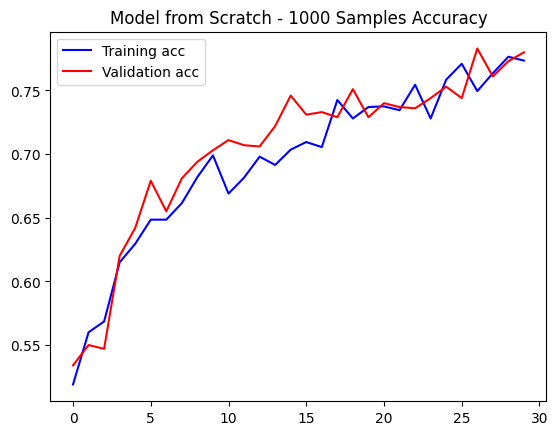

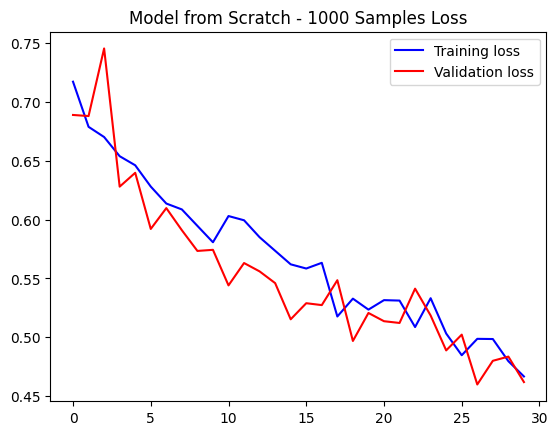

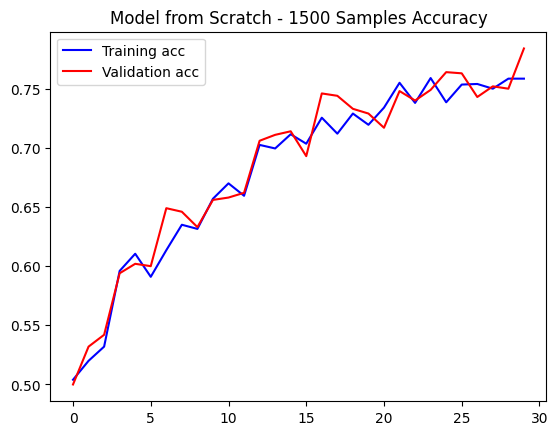

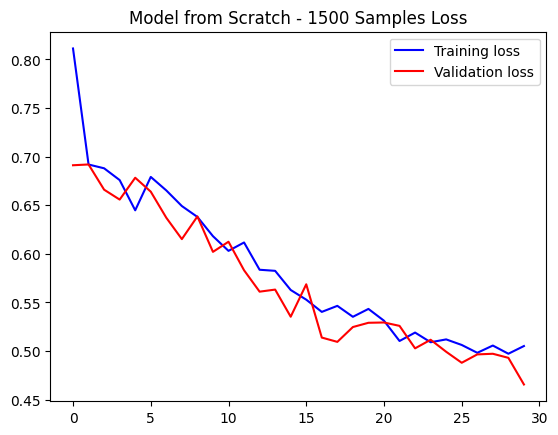

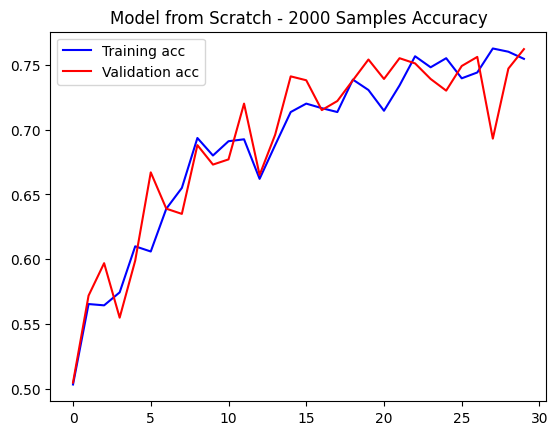

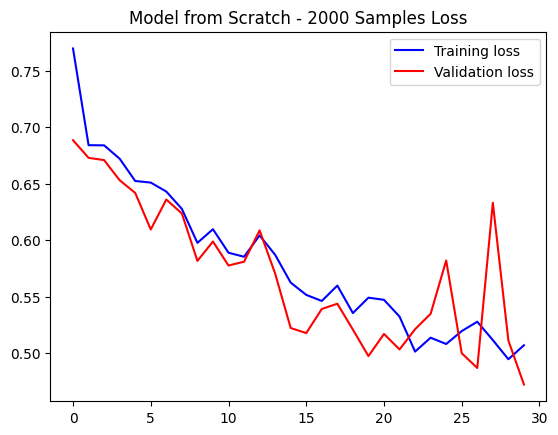

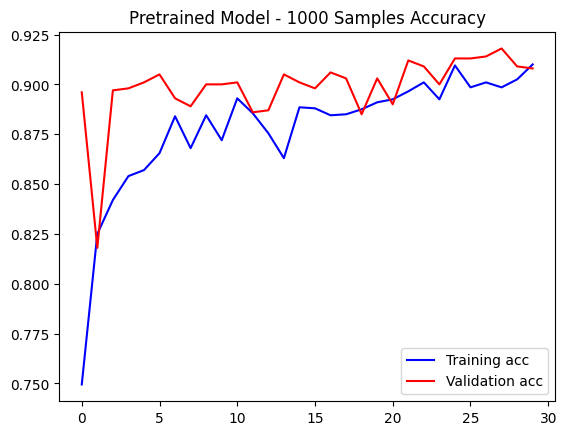

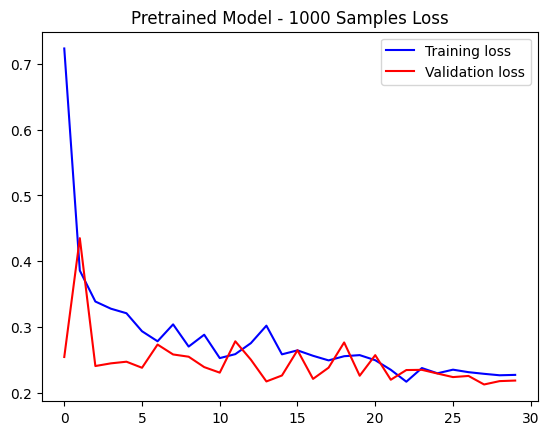

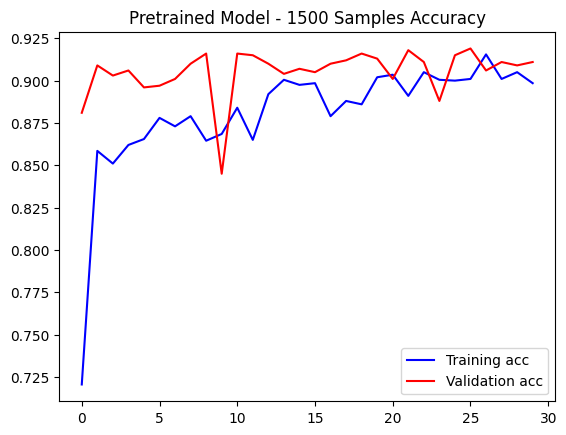

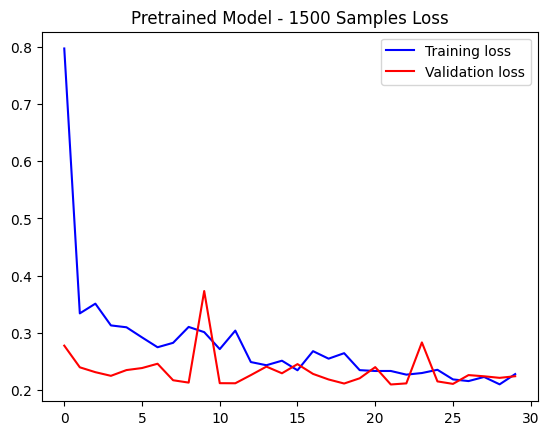

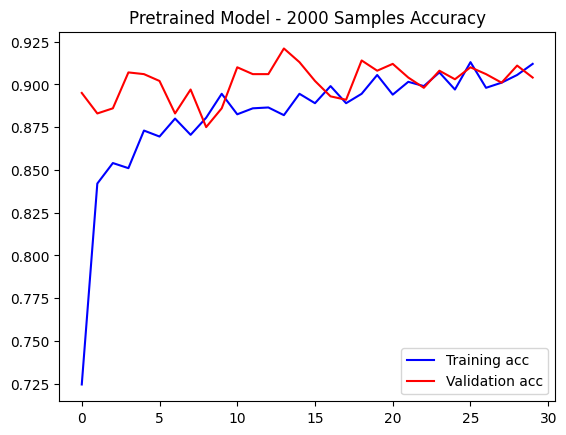

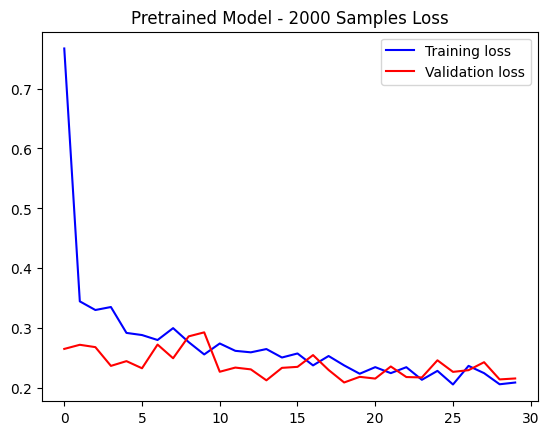

In [ ]:
# Performance visualization function
def visualize_performance(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(title + ' Accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title + ' Loss')
    plt.legend()
    plt.show()

# Plotting performance for each model
visualize_performance(history_A, 'Model from Scratch - 1000 Samples')
visualize_performance(history_B, 'Model from Scratch - 1500 Samples')
visualize_performance(history_C, 'Model from Scratch - 2000 Samples')
visualize_performance(history_P1, 'Pretrained Model - 1000 Samples')
visualize_performance(history_P2, 'Pretrained Model - 1500 Samples')
visualize_performance(history_P3, 'Pretrained Model - 2000 Samples')

**Result Aggregation for Summary Metrics**
This function neatly summarizes final training and validation performance for all models, making it easy to compare and report outcomes. The structured output is ideal for drawing conclusions about the impact of training size and the use of pretrained models.

In [ ]:
# Function to summarize final results
def aggregate_results(all_histories, model_labels):
    summary = {}

    for i, history in enumerate(all_histories):
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]

        summary[model_labels[i]] = {
            'Final Training Accuracy': final_train_acc,
            'Final Validation Accuracy': final_val_acc,
            'Final Training Loss': final_train_loss,
            'Final Validation Loss': final_val_loss,
        }

    return summary

# Example of using the aggregate_results function
all_histories = [history_A, history_B, history_C,
             history_P1, history_P2, history_P3]

model_labels = [
    'Model from Scratch - 1000 Samples',
    'Model from Scratch - 1500 Samples',
    'Model from Scratch - 2000 Samples',
  'Pretrained Model - 1000 Samples',
    'Pretrained Model - 1500 Samples',
    'Pretrained Model - 2000 Samples'
]

# Get the summary of final values only

**Visual Comparison of Final Model Performances**
This final visualization function gives a concise side-by-side comparison of training and validation metrics across all models. The use of line plots with markers helps emphasize performance trends, and rotating the labels improves readability—excellent for wrapping up your experiment.

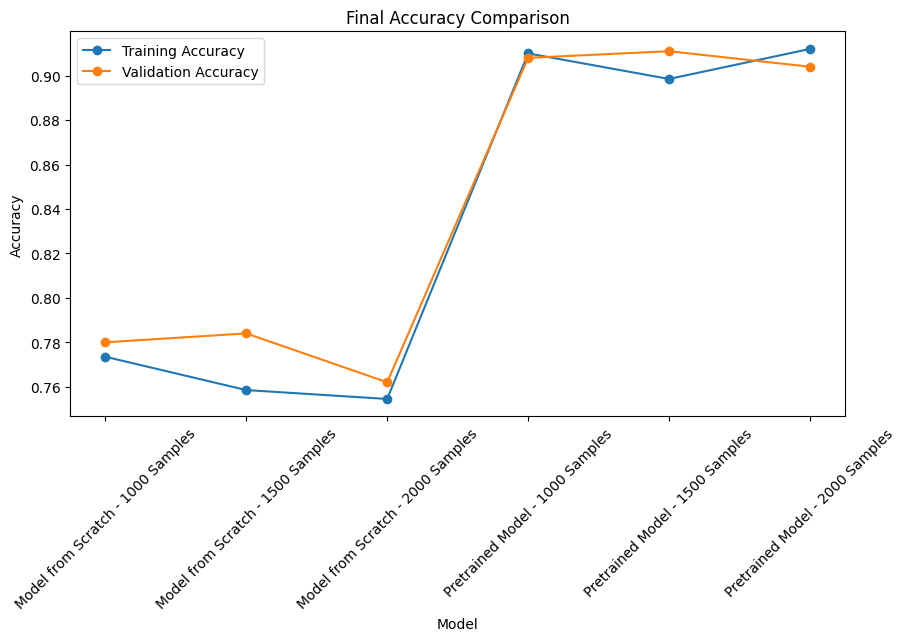

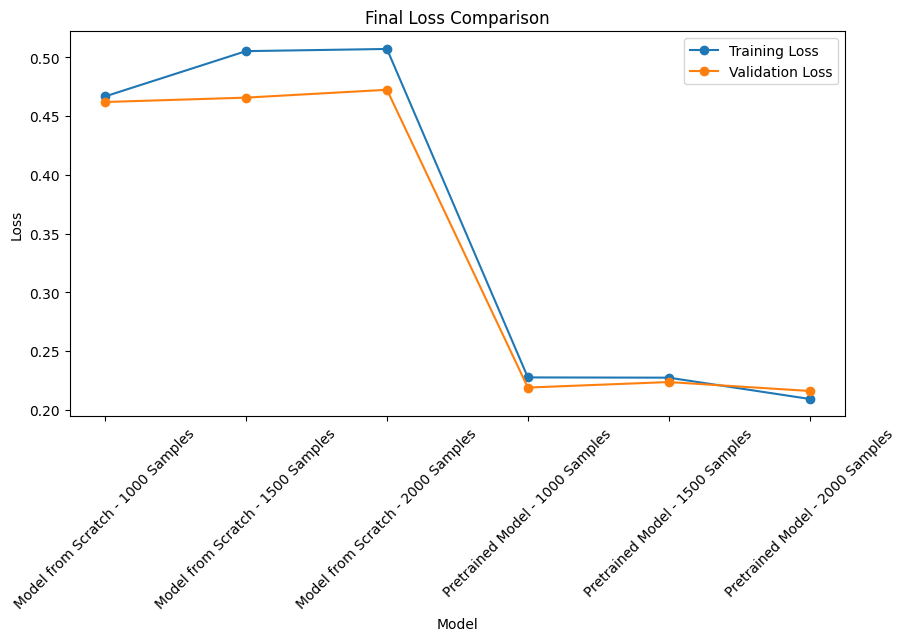

In [ ]:
# Function to compare model performances visually
def compare_models(final_scores):
    model_labels = list(final_scores.keys())
    train_acc = [final_scores[label]['Final Training Accuracy'] for label in model_labels]
    val_acc = [final_scores[label]['Final Validation Accuracy'] for label in model_labels]
    train_loss = [final_scores[label]['Final Training Loss'] for label in model_labels]
    val_loss = [final_scores[label]['Final Validation Loss'] for label in model_labels]

    # Accuracy comparison plot
    plt.figure(figsize=(10, 5))
    plt.plot(model_labels, train_acc, label='Training Accuracy', marker='o')
    plt.plot(model_labels, val_acc, label='Validation Accuracy', marker='o')
    plt.xticks(rotation=45)
    plt.title('Final Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss comparison plot
    plt.figure(figsize=(10, 5))
    plt.plot(model_labels, train_loss, label='Training Loss', marker='o')
    plt.plot(model_labels, val_loss, label='Validation Loss', marker='o')
    plt.xticks(rotation=45)
    plt.title('Final Loss Comparison')
    plt.xlabel('Model')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call aggregate_results to get the final scores
final_scores = aggregate_results(all_histories, model_labels) # This line was added

# Plot the comparisons
compare_models(final_scores)